# **Лабораторная работа №4:**
Задача регрессии, архитектуру выбирайте самостоятельно из уже примененных. Подсчет количества людей в толпе на снимке, датасет - https://www.kaggle.com/datasets/fmena14/crowd-counting. Задачи: обучить нейросеть и проверить её работу на тестовых данных, а также включить в неё кастомный callback, который должен будет в конце каждой итерации сравнивать значения функции потерь на этой эпохе с её значениями на предыдущей и выводить на экран, во сколько раз изменилось это значение (начиная со второй эпохи).  Помимо этого нужно построить гистограмму для валидационной выборки (по X - количество людей, по Y - количество картинок с таким количеством), и с помощью коллбэка выводить в конце каждой эпохи гистограммы, где по оси X - предсказанные нейросетью значения количества людей на картинке.

## **Готовим датасет**

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from keras import layers, models
from keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d fmena14/crowd-counting
!unzip crowd-counting

In [ ]:
labels_df = pd.read_csv('labels.csv')
image_folder = '/content/frames/frames/'

images = []
counts = []

for index, row in labels_df.iterrows():
    img_id = row['id']
    img_path = os.path.join(image_folder, f'seq_{img_id:06d}.jpg')
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    images.append(img)
    counts.append(row['count'])

images = np.array(images)
counts = np.array(counts)


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(images, counts, test_size=0.4, random_state=42)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## **Создаем модель сверточной нейронной сети**

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

## **Кастомный callback**

In [ ]:
def on_epoch_end(epoch, logs):
    if epoch > 0:
        loss_ratio = logs['loss'] / on_epoch_end.previous_loss
        print(f' Loss ratio: {loss_ratio:.2f}')
        
        # Предсказываем значения на валидационной выборке
        y_pred = model.predict(X_val)
        
        # Строим гистограмму
        plt.figure(figsize=(10, 5))
        bins = np.linspace(0, max(y_val.max(), y_pred.max()), 21)
        plt.hist(y_val, bins=bins, alpha=0.5, label='True counts', color='blue')
        plt.hist(y_pred, bins=bins, alpha=0.5, label='Predicted counts', color='orange')
        plt.xlabel('Number of people')
        plt.ylabel('Number of images')
        plt.legend()
        plt.show()

    on_epoch_end.previous_loss = logs['loss']
#делаем callback из нашей функции
callback = LambdaCallback(on_epoch_end=on_epoch_end)

## **Обучаем модель**

Epoch 1/6
38/38 [==============================] - 86s 2s/step - loss: 501225.1250 - mae: 159.1327 - val_loss: 63.3348 - val_mae: 6.2130
Epoch 2/6
13/13 [==============================] - 7s 541ms/step


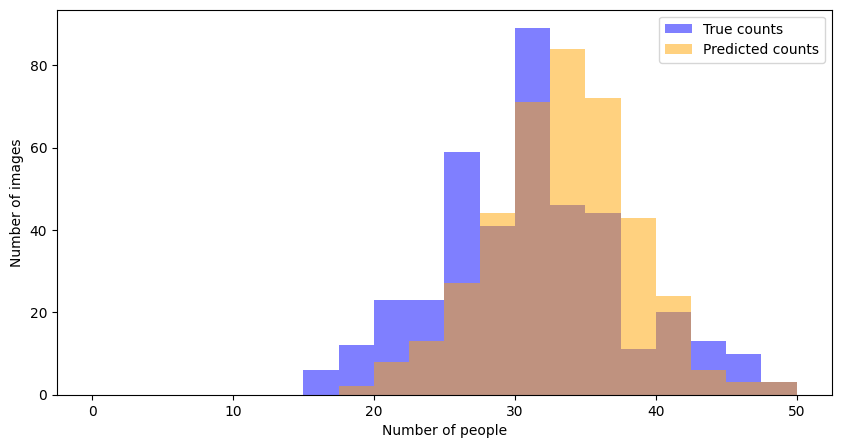

38/38 [==============================] - 95s 3s/step - loss: 50.2069 - mae: 5.5535 - val_loss: 23.3214 - val_mae: 3.9633
Epoch 3/6
13/13 [==============================] - 6s 487ms/step


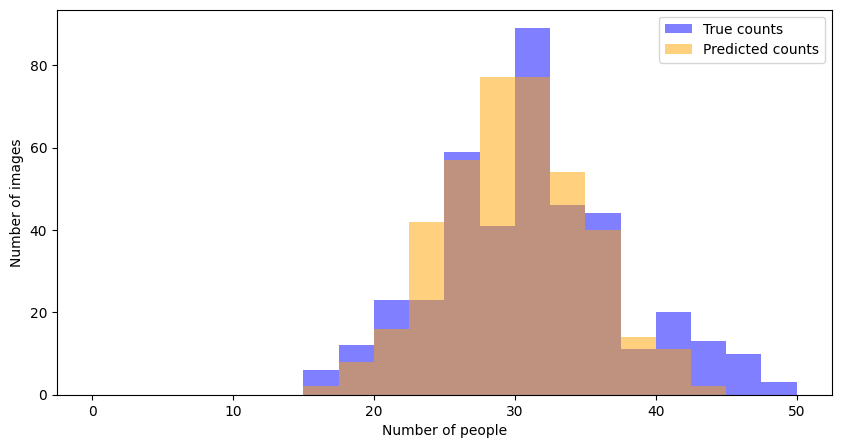

38/38 [==============================] - 93s 2s/step - loss: 13.4665 - mae: 2.8474 - val_loss: 12.5332 - val_mae: 2.7519
Epoch 4/6
13/13 [==============================] - 6s 485ms/step


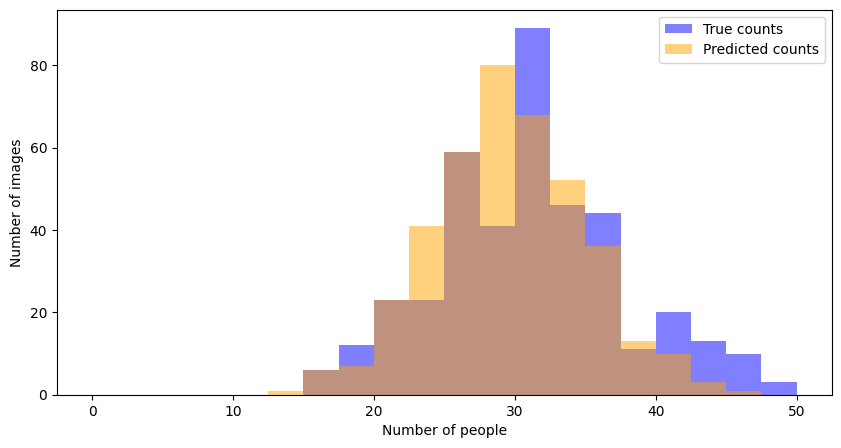

38/38 [==============================] - 95s 3s/step - loss: 5.8267 - mae: 1.8722 - val_loss: 11.1201 - val_mae: 2.6315
Epoch 5/6
13/13 [==============================] - 7s 507ms/step


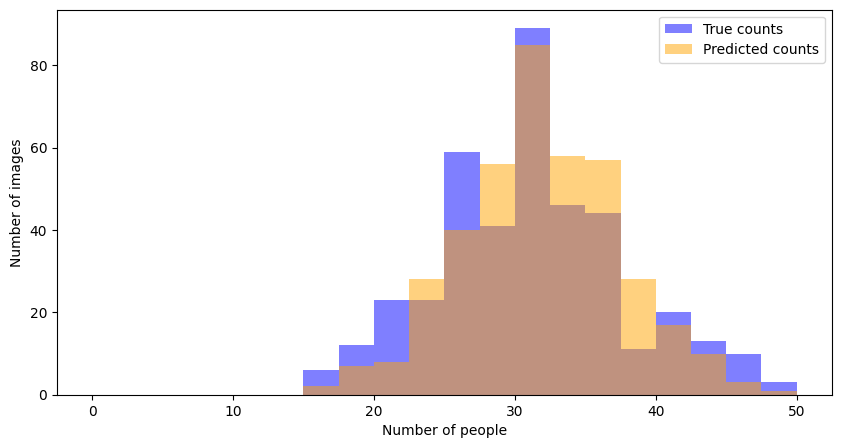

38/38 [==============================] - 93s 2s/step - loss: 3.7076 - mae: 1.5159 - val_loss: 10.1871 - val_mae: 2.5147
Epoch 6/6
13/13 [==============================] - 7s 510ms/step


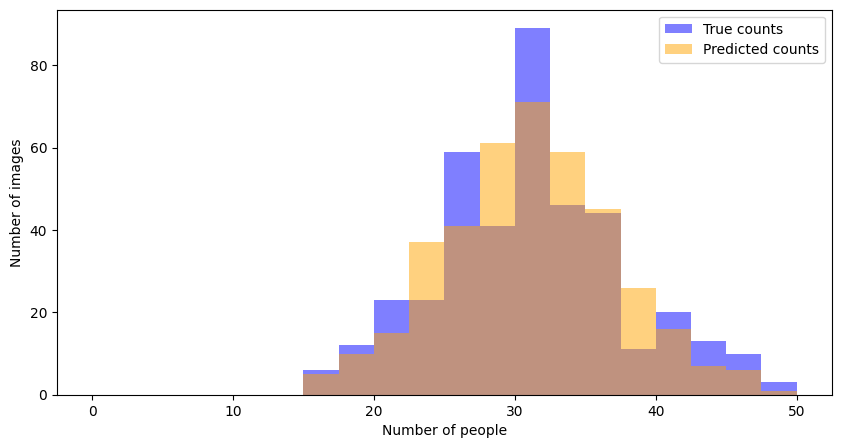

38/38 [==============================] - 97s 3s/step - loss: 2.3153 - mae: 1.2059 - val_loss: 8.1768 - val_mae: 2.2364


In [ ]:
history = model.fit(X_train, y_train, epochs=6, validation_data=(X_val, y_val), callbacks=[callback])

После обучения модели на 6 эпохах было принято отсноавится, потому что далее модель ошибка начинает возрастать. На данный момент, моедль ошибается в среднем на 1-2 человека.

In [ ]:
test_loss, test_mae = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

13/13 [==============================] - 7s 576ms/step - loss: 9.8062 - mae: 2.4622
Test Loss: 9.8062
Test MAE: 2.4622


Это и доказывает предсказания для нашей модели, где также видно, что ошибка будет на 1-2 человека. Считаю, что это не плохой результат для такого кол-ва человек.

## **График обучения и валидации**

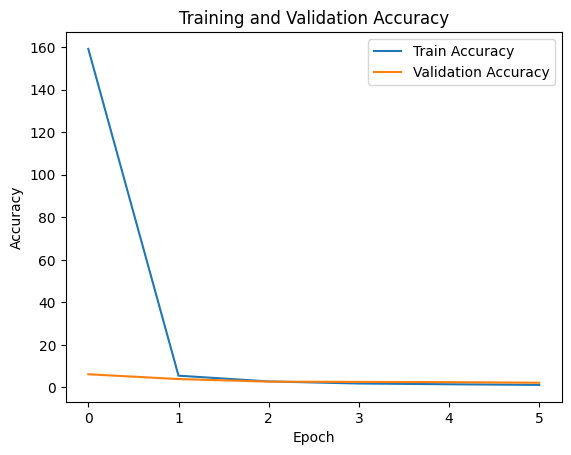

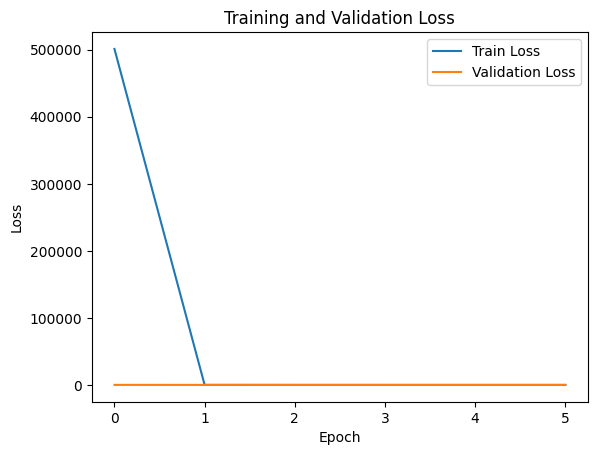

In [ ]:
train_acc = history.history['mae']
val_acc = history.history['val_mae']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()